In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [74]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from matplotlib.pyplot import figure
from scipy.stats import norm
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scipy import stats
from sklearn import metrics


# I. Data Wrangling
## 1. Primary Exploratory Data Analysis
### 1.1. Dataset
 I have chosen to work on an interesting dataset that I found on the NASA’s website
(https://data.nasa.gov/Space-Science/Meteorite-Landings/gh4g-9sfh), encompassing the
complete list of around 45000 meteorite landings on earth since the year 601. Each meteorite
is further described by the 10 columns listed below:

▪ name: the name of the meteorite (typically a location, often modified with a
number, year, composition, etc)

▪ id: a unique identifier for the meteorite

▪ nametype: one of: -- valid: a typical meteorite -- relict: a meteorite that has
been highly degraded by weather on Earth

▪ recclass: the class of the meteorite; one of a large number of classes based on
physical, chemical, and other characteristics

▪ mass: the mass of the meteorite, in grams

▪ fall: whether the meteorite was seen falling, or was discovered after its
impact; one of: -- Fell: the meteorite's fall was observed -- Found: the
meteorite's fall was not observed

▪ year: the year the meteorite fell, or the year it was found (depending on the
value of fell)

▪ reclat: the latitude of the meteorite's landing

▪ reclong: the longitude of the meteorite's landing

▪ GeoLocation: a parentheses-enclose, comma-separated tuple that
combines reclat and reclong

In [33]:
# Reading the CSV file
# The result is a Pandas DataFrame (data). A datatype easy to read
data = pd.read_csv('/users/youcefdjeddar/downloads/meteorite-landings.csv')

In [34]:
# Exploring the data using the .head() method 
data.head(3)

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"


In [35]:
# Looking for missing values 
missing_values_count = data.isnull().sum() 
print(missing_values_count)

name              0
id                0
nametype          0
recclass          0
mass            131
fall              0
year            288
reclat         7315
reclong        7315
GeoLocation    7315
dtype: int64


In [36]:
# Checking that the ID column has unique values
data['id'].is_unique

True

In [37]:
# Determining the percentage of missing values for each column
mass_missing_values = (missing_values_count['mass']/len(data.mass)) * 100 
year_missing_values = (missing_values_count['year']/len(data.year)) * 100 
location_missing_values = (missing_values_count['GeoLocation']/len(data.GeoLocation)) * 100
print('The percentage of missing values in the mass column is:', mass_missing_values,'%')
print ('The percentage of missing values in the year column is:', year_missing_values,'%') 
print('The percentage of missing values in the location column is:', location_missing_values,'%')

The percentage of missing values in the mass column is: 0.28655175430921337 %
The percentage of missing values in the year column is: 0.6299763758859043 %
The percentage of missing values in the location column is: 16.0009624639076 %


In [38]:
# Since it is impossible to guess the values of the missing data, it is preferable to delete them 
# We can see that all the missing values are gone
data = data.dropna()
data.isnull().sum()

name           0
id             0
nametype       0
recclass       0
mass           0
fall           0
year           0
reclat         0
reclong        0
GeoLocation    0
dtype: int64

In [39]:
# Getting some information about our dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38116 entries, 0 to 45715
Data columns (total 10 columns):
name           38116 non-null object
id             38116 non-null int64
nametype       38116 non-null object
recclass       38116 non-null object
mass           38116 non-null float64
fall           38116 non-null object
year           38116 non-null float64
reclat         38116 non-null float64
reclong        38116 non-null float64
GeoLocation    38116 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 3.2+ MB


In [40]:
# Let's see how many meteorite classes the dataset has
meteorite_class = data['recclass'].value_counts() 
print(meteorite_class)

L6                 7519
H5                 6243
H6                 3898
H4                 3880
L5                 3264
LL5                2199
LL6                1660
L4                  939
H4/5                395
CM2                 330
H3                  313
CO3                 308
Iron, IIIAB         270
L3                  268
LL                  223
Ureilite            214
E3                  205
LL4                 198
CV3                 184
Howardite           179
Diogenite           178
Eucrite-pmict       169
H5/6                166
CR2                 116
Eucrite             115
Iron, IIAB          111
Mesosiderite        107
H~5                 106
Iron, ungrouped     105
LL3                  88
                   ... 
EH3/4-an              1
L3.3-3.7              1
H4(?)                 1
Mesosiderite-A2       1
LL6                   1
LL3.1-3.5             1
Stone-ung             1
L3.3-3.5              1
R3-4                  1
CR-an                 1
L3.0-3.9        

In [41]:
# Below we can see that the top ten classes encompass 30k meteorites, which is a lot
print('Top 10 meteorite classes:', meteorite_class[:10].sum())

Top 10 meteorite classes: 30327


In [42]:
# Nearly 80% of all the meteorites belong to one of the top ten classes
percentage_meteorites_in_the_top_ten_classes = (meteorite_class[:10].sum()/len(data)) * 100
print (percentage_meteorites_in_the_top_ten_classes)

79.56501206842272


Since 80% of the meteorites belong to one of the top ten classes, I will focus primarily on them.

In [43]:
# Extracting the needed data (from the top 10 classes)
top_10 = data['recclass'].value_counts().index.tolist()[:10]
df = data[data['recclass'].isin(top_10)]

In [44]:
len(df)

30327

The DataFrame "df" is now regrouping the meteorites of the top ten classes only. 

Let's now do some data visualization to understand more our data.

# II. Data Visualization
## 1. Intro
 The initial dataset from the NASA had 422 meteorite classes in it. A high number that did not
necessarily reflect the distribution of meteorites. Indeed, as shown in the Phase-1 (Data
Wrangling), the top ten meteorite classes encompassed approximately 80% of the total number
of meteorites. For that reason, I decided to neglect – for now, the remaining 20% of the data – for
a more concrete analysis.
## 2. Visualization
### 2.1. Scatter Plot
 After extracting the needed segments, I used the Matplotlib Library to generate a Scatter
Plot (meteorite classes on the x-axis and their mass on the y-axis) to see the distribution of the
mass per class. Surprisingly, with the notable exception of a few outliers, the distribution was
quite homogenous among the ten classes, with the majority of the meteorites having a mass
range 0-500kg. Here are some conclusions:

▪ The heaviest meteorite belongs to the H5 class;

▪ The class L6 is more homogenous;

▪ The class CM2 has the lightest meteorites.

### 2.2. Seaborn lmplot
 I used the Seaborn Library to visualize a sort of a time-series plot showing the distribution
of the landings throughout the entire timescale of the dataset. Not surprisingly, most of the landings
occurred after the 19th century, which can be explained by the restricted technological advances
prior to that time, where only landings that were actually observed by humans were recorded.
The third plot shows the mass of the meteorites that landed throughout the timescale. Here are
some conclusions:

▪ Accurate landing records really started in the 19th century;

▪ Recent meteorites seem to be heavier – which is probably due to the drastic
increase of the landing records recently. More records => more meteorite
landings => potentially heavier meteorites.
### 2.3. Plotly Library
#### 2.3.1. Scatter Plot
I opted for the Plotly Library for more esthetic plots. It’s a bit slower and requires an
API-Key to run adequately but it provides a variety of options that cannot be found
elsewhere. The scatter plot shows the distribution of the top ten meteorite classes. We
can learn, for example, that the L6 class is the oldest class observed and that the H4/5
class is contemporary.
#### 2.3.2. Scatter Map Box
This is, I believe, the most interesting plot provided by the Plotly Library. I tried to plot
the geo-location of about 35.000 the meteorite on the dataset, based on the latitude and
the longitude of the places where they landed. Surprisingly, only a minority of the
meteorites landed in the seas/oceans, despite them constituting around 70% of the
planet. 

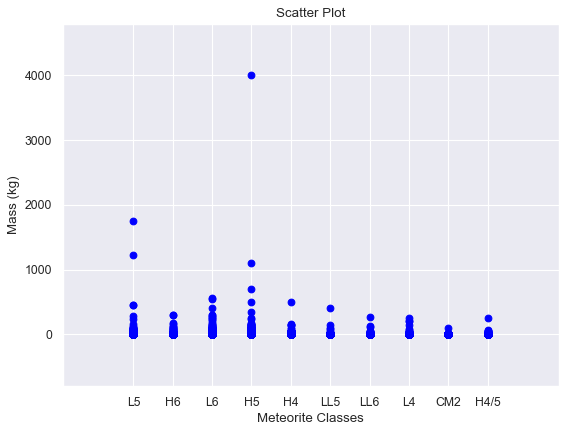

In [45]:
# Scatter plot of the ten meteorite classes on the x-axis and the mass of each meteorite on the y-axis
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.set()
plt.scatter(df.recclass, df.mass/1000, marker = 'o', color = 'blue', label = 'mass')
plt.xlabel('Meteorite Classes')
plt.ylabel('Mass (kg)')
plt.title('Scatter Plot')
plt.margins (0.2)

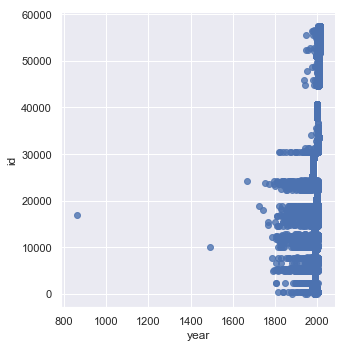

In [46]:
sns.lmplot('year', 'id', data=df, fit_reg=False)
# The plot shows that the landing frequency significantly increased starting from the 19th century

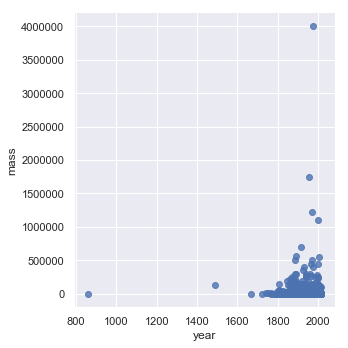

In [47]:
sns.lmplot('year', 'mass', data=df, fit_reg=False)
# The plot below shows that most of the contemporary meteorites are heavier

In [19]:
# Landings distribution on a map (using the properties lat and long)

mapbox_access_token = 'dhjrzm2c8j'
site_lat = df.reclat
site_lon = df.reclong
data = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=17,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
        hoverinfo='text'
    ),
    ]





fig = dict(data=data)

py.iplot(fig, filename='jupyter-Meteorite-Landings')

NameError: name 'go' is not defined

In [ ]:
# Landings distribution on a map (using the properties lat and long)

mapbox_access_token = 'dhjrzm2c8j'
site_lat = df.reclat
site_lon = df.reclong
data = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=17,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
        hoverinfo='text'
    ),
    ]





fig = dict(data=data)

py.iplot(fig, filename='jupyter-Meteorite-Landings')

## Note
Because the library required an API-Key to run, I couldn’t share the plots on the Jupyter Notebook. Screenshots of the Scatter Plots and the Scatter Map Box can be found here: https://github.com/youcefjd/Meteorite-Project-Phase-2/blob/master/Data%20Visualization.pdf

# III. Statistical Thinking
 Often, it is very useful to think "statistically". Numbers are the language of the universe, they help us understand things more clearly. Conducting a statistical analysis helped me to understand some "hidden" aspects of the dataset.
In this section, I tried to perform a coherent statistical analysis. The dataset being very tedious, the resulsts are quite restricted. However, they offer an interesting "plus-value".

In [48]:
# The method "describe" is always a great start
df.describe()

,id,mass,year,reclat,reclong
count,30327.000000,3.032700e+04,30327.000000,30327.000000,30327.000000
mean,25105.327464,1.534274e+03,1991.651861,-44.190882,67.709503
std,17101.950186,2.972658e+04,20.742622,44.862046,80.915431
min,1.000000,1.000000e-02,860.000000,-87.366670,-165.433330
25%,11165.500000,6.000000e+00,1986.000000,-79.683330,2.866670
50%,21329.000000,2.370000e+01,1996.000000,-71.787500,54.565330
75%,39372.500000,1.335500e+02,2002.000000,0.000000,159.282235
max,57457.000000,4.000000e+06,2013.000000,81.166670,175.730280


The "mass" column seems to be interesting. I will focus on analyzing it further. 

In [49]:
df.mass.describe()

count    3.032700e+04
mean     1.534274e+03
std      2.972658e+04
min      1.000000e-02
25%      6.000000e+00
50%      2.370000e+01
75%      1.335500e+02
max      4.000000e+06
Name: mass, dtype: float64

Text(0.5,1,'Seaborn Box Plot')

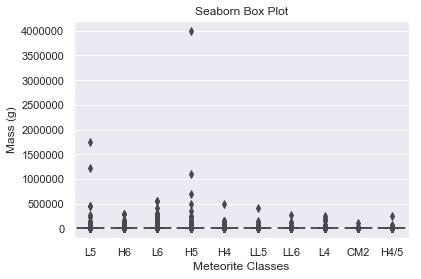

In [50]:
sns.boxplot(x ='recclass', y='mass', data = df)
plt.xlabel('Meteorite Classes')
plt.ylabel('Mass (g)')
plt.title('Seaborn Box Plot')

The Box Plot doesn't offer much indications. I will try to "zoom" on the y-axis, since the mass is on average in between 0 and 100g

Text(0.5,1,'Seaborn Box Plot')

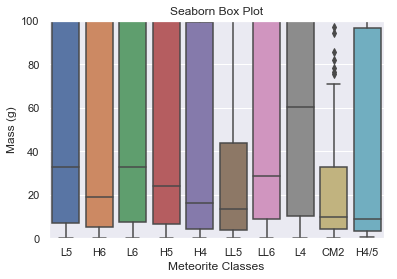

In [51]:
sns.boxplot(x ='recclass', y='mass', data = df)
plt.ylim(0, 100)
plt.xlabel('Meteorite Classes')
plt.ylabel('Mass (g)')
plt.title('Seaborn Box Plot')


Another interesting statistical figure is the EDF (Empirical Distribution Function). 

In statistics, an empirical distribution function is the distribution function associated with the empirical measure of a sample. This cumulative distribution function is a step function that jumps up by 1/n at each of the n data points. Its value at any specified value of the measured variable is the fraction of observations of the measured variable that are less than or equal to the specified value. - source Wikipedia

Another definition: 

An empirical cumulative distribution function (also called the empirical distribution function, ECDF, or just EDF) and a cumulative distribution function are basically the same thing: they are both probability models for data. However, while a CDF is a hypothetical model of a distribution, the ECDF models empirical (i.e. observed) data. To put this another way, the ECDF is the probability distribution you would get if you sampled from your sample, instead of the population. Let’s say you have a set of experimental (observed) data x1, x2 …,xn. The EDF will give you the fraction of sample observations less than or equal to a particular value of x.




Text(0.5,1,'EDF')

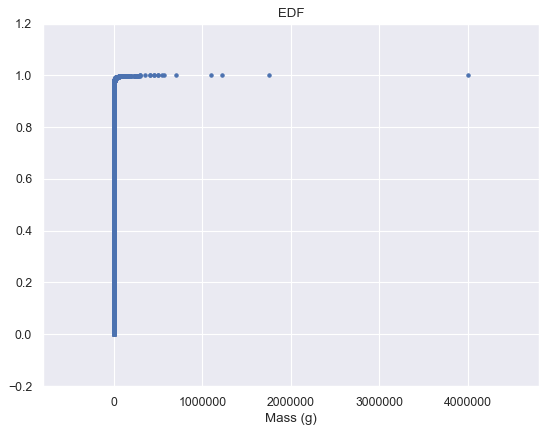

In [52]:
# Extracting the mass column and plotting it
x = np.sort(df.mass)
y = np.arange(1, len(x)+1)/len(x)
sns.set()
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(x, y, marker= '.', linestyle='none')
plt.xlim = (0, 1000000)
plt.margins(0.2)
plt.xlabel('Mass (g)')
plt.title('EDF')

The graph doesn't tell us a lot about the distribution of the data (the mass). There's another figure that could help us have more information about the distribution, it is called the PDF (Probability Density Function)

In probability theory, a probability density function (PDF), or density of a continuous random variable, is a function, whose value at any given sample (or point) in the sample space (the set of possible values taken by the random variable) can be interpreted as providing a relative likelihood that the value of the random variable would equal that sample.[citation needed] In other words, while the absolute likelihood for a continuous random variable to take on any particular value is 0 (since there are an infinite set of possible values to begin with), the value of the PDF at two different samples can be used to infer, in any particular draw of the random variable, how much more likely it is that the random variable would equal one sample compared to the other sample. - source Wikipedia

Text(0.5,0,'Mass (g)')

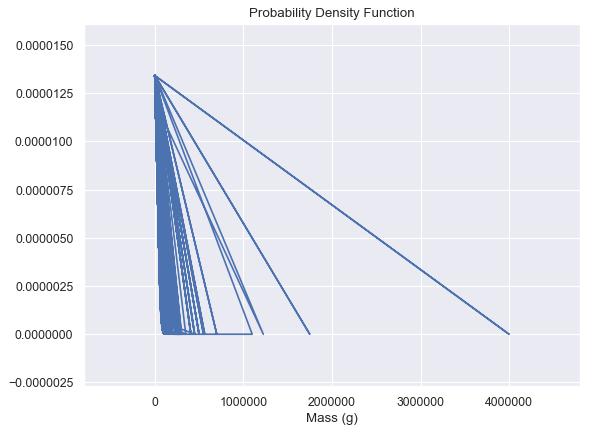

In [53]:
mass = df.mass
mean = np.mean(mass)
std = np.std(mass)
length = len(df)
p=norm.pdf(mass, mean, std)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(mass, p)
plt.margins(0.2)
plt.title ('Probability Density Function')
plt.xlabel('Mass (g)')

The PDF has a weird shape. It doesn't tell us a lot about the distribution either. 

Last thing, we know that the mean of our population is 1.534274e+03g. But is it the true mean? To make sure that it is the case it is advisable to perform a z-test.

## What is a t-score?

Simply put, a t-score is the number of standard deviations from the mean a data point is. It helps us to determine the true mean of our population.

## Why a t-test and not a z-test?

Simply because the standard deviation of our sample is uknown. Though a t-test is best for small samples, it becomes similar to the z-test with large samples, so the results shouldn't differ much.

## Performing a t-test 

### Null Hyothesis 

Ho: True Population Mean is 1.534274e+03g 

H1: True Population Mean is not 1.534274e+03g



In [54]:
# Save results of a one sample t-test:
t = stats.ttest_1samp(df.mass, 1534.2738281399413)[0]
p = stats.ttest_1samp(df.mass, 1534.2738281399413)[1]

print('t-statistic:', t)
print('p-value:', p)

t-statistic: 0.0
p-value: 1.0


The results tell us unequivocally that the true mean of the population is indeed  1534.2738281399413g.

## Conclusion

The dataset is not normally distributed. After some statistical analysis I haven't learnt a lot about it. It was worth trying though.

# IV. Machine Learning 

Here comes the fun part: machine learning. The dataset being very tedious, I am not expecting miracles. However, I am certain that using the right algorithms I can predict something interesting. 

## Note

I have tried numerous algorithms on the dataset. My experiments can be found here: https://github.com/youcefjd/Meteorite-Project-Phase-4/blob/master/Machine_Learning%20(1).ipynb

I am, here, going to use what I learned from the experiments to directly apply the best algorithms on the dataset.

### What to predict?

Based on some selected features, I will try to predict where the next meteorite landing will occur. A bit ambitious but worth a try.

### Random Forests Regressor

From my experiments, I have determined that RFR is the algorithm that gives the best results on the dataset. 

In [55]:
# Making sure that we have no NaNs
df.isnull().sum()

name           0
id             0
nametype       0
recclass       0
mass           0
fall           0
year           0
reclat         0
reclong        0
GeoLocation    0
dtype: int64

In [56]:
df.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"
7,Agen,392,Valid,H5,30000.0,Fell,1814.0,44.21667,0.61667,"(44.216670, 0.616670)"
8,Aguada,398,Valid,L6,1620.0,Fell,1930.0,-31.60000,-65.23333,"(-31.600000, -65.233330)"


In [61]:
# Selecting the features and the target variable 

X = df[['recclass', 'mass', 'year']] # Selecting the class of the meteorite, their mass and the predicted landing year
y = df[['reclat', 'reclong']] # The target variable represents the latitude and longitude of the expected landing

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

In [63]:
rfr = RandomForestRegressor().fit(X_train, y_train)

/Users/youcefdjeddar/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: 'L6'

Scikit learn does not support string variables. An encoding is therefore necessary. We have two options, the "get_dummies" method or the Label Encoder furnished by sklearn. The former creates a column for each string sample and the latter replaces each string by a number in the same column (mapping).

I will choose the Label Encoder since it requires less memory.

In [64]:
from sklearn.preprocessing import LabelEncoder
df['recclass'] = LabelEncoder().fit_transform(df['recclass'])

/Users/youcefdjeddar/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [65]:
df.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,6,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,4,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
4,Achiras,370,Valid,7,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"
7,Agen,392,Valid,3,30000.0,Fell,1814.0,44.21667,0.61667,"(44.216670, 0.616670)"
8,Aguada,398,Valid,7,1620.0,Fell,1930.0,-31.60000,-65.23333,"(-31.600000, -65.233330)"


As we can see, all the classes have been replaced by a number, unique to each class.

In [66]:
X = df[['recclass', 'mass', 'year']] # Selecting the class of the meteorite, their mass and the predicted landing year
y = df[['reclat', 'reclong']] # The target variable represents the latitude and longitude of the expected landing

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
rfr = RandomForestRegressor().fit(X_train, y_train)

/Users/youcefdjeddar/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [68]:
print("Training set score: {:.2f}".format(rfr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rfr.score(X_test, y_test)))
%time rfr.fit(X_train, y_train)

Training set score: 0.92
Test set score: 0.53
CPU times: user 280 ms, sys: 9.85 ms, total: 290 ms
Wall time: 290 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Clear overfitting. However, the score on the test set is very good. The algorithm can now predict, with 53% accuracy, where exactly the next meteorite landing will occur. 

Random Forest has different parameters that we can explore to possibly enhance the score on the test set.

In [69]:
rfr = RandomForestRegressor(n_estimators = 1).fit(X_train, y_train)
print("Training set score: {:.2f}".format(rfr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rfr.score(X_test, y_test)))
%time rfr.fit(X_train, y_train)

Training set score: 0.74
Test set score: 0.33
CPU times: user 37.9 ms, sys: 1.27 ms, total: 39.2 ms
Wall time: 40.9 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Random Forest with one single estimator is equivalent to the decision tree algorithm.

Below are further exploration of the algorithm in order to prevent it from overfitting. I will also attempt to play around with some parameters to find the best combination for the dataset. 

## Cross Validation

In [70]:
rfr = RandomForestRegressor(n_estimators = 20, min_samples_leaf = 3, max_features = 0.5, n_jobs = 1).fit(X_train, y_train)
print("Training set score: {:.2f}".format(rfr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rfr.score(X_test, y_test)))
%time rfr.fit(X_train, y_train)

Training set score: 0.77
Test set score: 0.58
CPU times: user 245 ms, sys: 6.8 ms, total: 252 ms
Wall time: 253 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [75]:
kfold = KFold(n_splits=15, shuffle=True, random_state=0)
scores = cross_val_score(rfr, X_test, y_test, cv =kfold)  
print("Average cross-validation score: {:.2f}".format(scores.mean()))
%time cross_val_score(rfr, X_test, y_test, cv =kfold)

Average cross-validation score: 0.57
CPU times: user 1.14 s, sys: 7.37 ms, total: 1.15 s
Wall time: 1.17 s


array([0.64982, 0.53514, 0.63638, 0.57458, 0.5523 , 0.55414, 0.50895, 0.5927 , 0.55157, 0.60854, 0.58165,
       0.63729, 0.52837, 0.5692 , 0.53049])

In [76]:
kfold = KFold(n_splits=15, shuffle=False, random_state=0)
scores = cross_val_score(rfr, X_test, y_test, cv =kfold)  
print("Average cross-validation score: {:.2f}".format(scores.mean()))
%time cross_val_score(rfr, X_test, y_test, cv =kfold)

Average cross-validation score: 0.57
CPU times: user 1.18 s, sys: 9.42 ms, total: 1.19 s
Wall time: 1.21 s


array([0.58127, 0.60563, 0.55419, 0.64297, 0.58575, 0.57143, 0.57467, 0.53905, 0.52655, 0.57767, 0.58325,
       0.53887, 0.53536, 0.56473, 0.56671])

The results are quite encouraging. Let's see if the algorithm can do better.

## Grid Search 

In [77]:
# split data into train+validation set and test set 
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=0)
# split train+validation set into training and validation sets 
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print("Size of training set: {}    size of validation set: {}     size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))
best_score = 0
for n_estimators in [1, 10, 20,  50, 100, 200]:
    for min_samples_leaf in [1, 3, 10, 20, 50, 100]:
        for max_depth in [1, 2, 3, 4, 5, 10, 15]:
            for n_jobs in [-1, 1, 2, 5, 10]:
                rf = RandomForestRegressor(n_estimators = n_estimators,min_samples_leaf = min_samples_leaf,
                                      max_depth = max_depth, n_jobs = n_jobs )
                rf.fit(X_train, y_train)
                score = rf.score(X_valid, y_valid)
                if score > best_score:
                    best_score = score
                    best_parameters = {'n_estimators': n_estimators, 'min_samples_leaf': min_samples_leaf,
                              'max_depth': max_depth,'n_jobs': n_jobs}
                    rf = RandomForestRegressor(**best_parameters)
                    rf.fit(X_trainval, y_trainval)
                    test_score = rf.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score)) 
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 17058    size of validation set: 5687     size of test set: 7582

Best score on validation set: 0.63
Best parameters:  {'n_estimators': 100, 'min_samples_leaf': 10, 'max_depth': 15, 'n_jobs': -1}
Test set score with best parameters: 0.63


The function selects the best values of the four parameters. 

In [82]:
rfr = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, max_depth = 15, n_jobs = -1, oob_score = True).fit(X_train, y_train)
print("Training set score: {:.2f}".format(rfr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rfr.score(X_test, y_test)))
%time rfr.fit(X_train, y_train)

Training set score: 0.69
Test set score: 0.62
CPU times: user 2.25 s, sys: 15.4 ms, total: 2.26 s
Wall time: 833 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

## Understanding Grid Search  
The reason why I chose to incorporate the validation set into the function is simple: 

I used the test data to adjust the parameters, I can no longer use it to assess how good the model is. This is the same reason we traditionally need to split the data into training and test sets in the first place; we need an independent dataset to evaluate, one that was not used to create the model.

## Understanding the selected parameters

n_estimators = number of trees in the foreset

max_depth = max number of levels in each decision tree

min_samples_leaf = min number of data points allowed in a leaf node

n_jobs = The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. 

## Machine Learning Results 

Using Random Forest Regressor, the algorithm was able to determine, with 62% accuracy, where EXACTLY the next meteorite landings will occur, based only on the class, the mass and the expected landing year of the meteorites. Very encouraging results. 

# V. Capstone Project Summary 

During this interesting journey, the following objectives were reached: 

1. The dataset was properly cleaned;
2. The dataset was separated into different segments, each segment having a specific purpose;
3. Important segments were adequatly visualized via scatter plots, histograms, box plots and map boxes;
4. Interesting statistical analysis were conducted on the dataset (t-test, EDF, PDF...); 
5. The dataset was correctly encoded to be ready for the machine learning part;
6. After experimenting different machine learning algorithms (supervised and unsupervised) and combinations (classification and regression), Random Forest Regressor was always giving satisfying results;
7. After a multitude of tests, determining where the next meteorite landings will occur was the most realistic prediction;
8. With only three features that can be observed and determined via telescopes, the algorithm was giving a fair score;
9. A cross validation and a grid search were performed on the dataset to enhance the test score and to reduce over-fitting, sucessfully. 
